# Undestanding the opioid crisis with a modified epidemic model
----

In [9]:
import numpy as np
import pandas as pd
import scipy as sp
import time
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### The system of equations

In [535]:
def opioid(state, t, alpha, epsilon, beta, xi, gamma, zeta, delta, nu, sigma, mu, mu_star):
    S, P, A, R = state
    S_prime = -alpha*S - beta*(1-xi)*S*A - beta*xi*S*P + epsilon*P + delta*R + mu*(P+R) + mu_star*A
    P_prime = alpha*S - (epsilon + gamma + mu)*P
    A_prime = gamma*P + sigma*R + beta*(1-xi)*S*A + beta*xi*S*P + nu*R*A - (zeta + mu_star)*A
    R_prime = zeta*A - nu*R*A - (delta + sigma + mu)*R
    #P_prime = -(A_prime + R_prime + S_prime)
    return [S_prime, P_prime, A_prime, R_prime]

### Our parameters

In [567]:
# parameters
epsilon = 0.74 # P to S rate
xi = 0.505 #  fraction of beta due to P
gamma = 0.26 # rate of addiction among prescribed users
nu = 0.2 # relapse rate of R due to A pressure
sigma = 0.7 # natural relapse rate of R 
mu = 0.00824 # death rate
mu_star = 0.00834 # death rate of addicts

delta = 0.1 # R to S rate. 0.1 is default
beta = 0.0625 # total addiction rate for S due to illegal access

alpha = 0.5 # prescription rate. could be 0-1
zeta = 0.5 # rate of A entry into rehab. could be 0-1

# Need to enforce sigma + nu + delta = 1 and epsilon + gamma = 1

print (epsilon + gamma)
sigma + nu + delta

1.0


0.9999999999999999

In [577]:
alphas = np.linspace(0,1,num=101)
zetas = np.linspace(0,1,num=101)
X, Y = np.meshgrid(alphas, zetas)
Z = np.empty(X.shape)

In [589]:
for i in range(X.shape[0]):
    if i%10==0: print i
    for j in range(X.shape[0]):
        alpha = X[i,j]
        zeta = Y[i,j]
        numerical_sol = sp.integrate.odeint(opioid, state0, t, args=(alpha, epsilon, beta, xi, gamma, zeta, delta, nu, sigma, mu, mu_star))
        Z[i,j] = numerical_sol[-1,1]

0
10
20
30
40
50
60
70
80
90
100


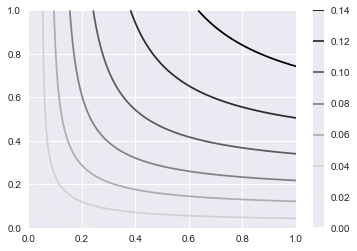

In [590]:
plt.contour(X, Y, Z)
plt.colorbar()

### Parameters that will lead to addiction free rate according to paper

### Solve the system

In [620]:
t = np.linspace(0, 15, 1501)
GM = 1.0
state0 = [0.87, 0.1, 0.02, 0.01]
alpha = 0.2 # prescription rate. could be 0-1
zeta = 0.5 # rate of A entry into rehab. could be 0-1
numerical_sol = sp.integrate.odeint(opioid, state0, t, args=(alpha, epsilon, beta, xi, gamma, zeta, delta, nu, sigma, mu, mu_star))

S = numerical_sol[:,0]
P = numerical_sol[:,1]
A = numerical_sol[:,2]
R = numerical_sol[:,3]

### Check that the population is constant

In [621]:
S+P+A+R

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

### Plot the percentage of addicts over time

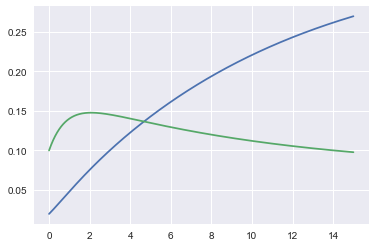

In [622]:
plt.plot(t, A)
plt.plot(t, P)

### Plot the estimated number of deaths due to drug overdose over time (does not account for age, gender, etc. so likely is an underestimate)

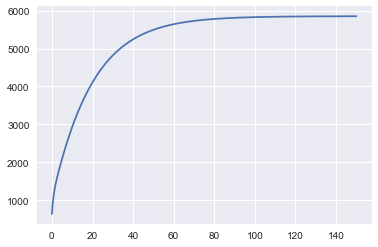

In [556]:
plt.plot(t, 320000000*(mu_star-mu)*A)

### Import data

In [390]:
data = pd.read_csv('NCHS_-_Drug_Poisoning_Mortality_by_State__United_States (1).csv')
data.columns = [u'Year', u'Sex', u'Age', u'Race', u'State', 
                u'Deaths', u'Population', u'Crude Death Rate', 
                u'Standard Error for Crude Rate', u'Low Confidence Limit for Crude Rate', 
                u'Upper Confidence Limit for Crude Rate', u'Age-adjusted Rate', 
                u'Standard Error Age-adjusted Rate', 
                u'Lower Confidence Limit for Age-adjusted rate', 
                u'Upper Confidence Limit for Age-adjusted Rate', 
                u'State Crude Rate in Range', u'US Crude Rate', 
                u'US Age-adjusted Rate']

In [391]:
data = data.query('Age== "All Ages" & Sex=="Both Sexes" & Race=="All Races-All Origins" & State!="United States"')

In [392]:
data['Deaths'] = data['Deaths'].apply(lambda x: x.replace(',',''))
data['Deaths'] = pd.to_numeric(data['Deaths'], errors='coerce')
data['Population'] = data['Population'].apply(lambda x: x.replace(',',''))
data['Population'] = pd.to_numeric(data['Population'], errors='coerce')
data['Age-adjusted Rate'] = data['Age-adjusted Rate']*data['Population']/100000
result = data.groupby(['Year'])['Deaths'].sum()
result = result.reset_index()

In [394]:
data['State'].unique().shape

(51,)

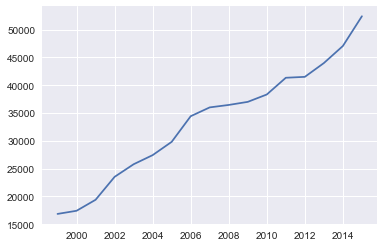

In [395]:
plt.plot(result['Year'],result['Deaths'])

### County level exploration

In [315]:
data = pd.read_csv('NCHS_-_Drug_Poisoning_Mortality_by_County__United_States (1).csv')
split = data['Estimated Age-adjusted Death Rate, 16 Categories (in ranges)'].apply(lambda x: x.split('-'))
split['lower'] = split.apply(lambda x: x[0])
def getUpper(x):
    try:
        return x[1]
    except: return x[0]
split['upper'] = split.apply(getUpper)

In [316]:
data['lower'] = pd.to_numeric(split['lower'], errors='coerce')
data['lower'] = data['lower']*data['Population']/100000
data['upper'] = pd.to_numeric(split['upper'], errors='coerce')
data['upper'] = data['upper']*data['Population']/100000
result = data.groupby(['Year'])['upper'].sum()
result = result.reset_index()

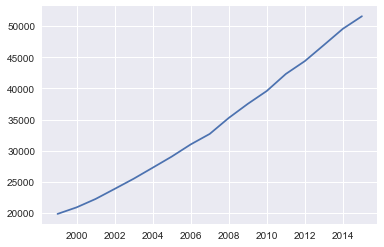

In [320]:
plt.plot(result['Year'],result['upper'])